Đây là notebook chứa end-to-end pipeline

Mỗi notebook chỉ chứa 1 model thôi nhé

## Installations

## Data Preparation

Bước này đã được chuẩn bị ở notebook Data Preparation.

split_v3 https://drive.google.com/file/d/1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu/view?usp=drive_link

In [1]:
# Download dataset
!gdown 1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu
!unzip splits_v3.zip

Streaming output truncated to the last 5000 lines.
  inflating: splits_v3/train/glass/glass_489.jpg  
  inflating: splits_v3/train/glass/glass_566.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2822_glass_19.jpg  
  inflating: splits_v3/train/glass/glass_591.jpg  
  inflating: splits_v3/train/glass/glass_616.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2816_glass_2.jpg  
  inflating: splits_v3/train/compost/compost_1276.jpg  
  inflating: splits_v3/train/glass/glass_574.jpg  
  inflating: splits_v3/train/compost/compost_1251.jpg  
  inflating: splits_v3/train/compost/compost_1212.jpg  
  inflating: splits_v3/train/compost/compost_1178.jpg  
  inflating: splits_v3/train/glass/glass_465.jpg  
  inflating: splits_v3/train/glass/glass_571.jpg  
  inflating: splits_v3/train/compost/compost_1173.jpg  
  inflating: splits_v3/train/compost/compost_1176.jpg  
  inflating: splits_v3/train/compost/compost_1190.jpg  
  inflating: splits_v3/train/glass/glass_499.jpg  
  inflating: s

### Load datasets

In [2]:
TRAIN_PATH = '/content/splits_v3/train'
DEV_PATH = '/content/splits_v3/validation'
TEST_PATH = '/content/splits_v3/test'

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Data flow
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3260 images belonging to 7 classes.


In [4]:
# Data generators
valid_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment valid set

valid_generator = valid_datagen.flow_from_directory(
    directory=DEV_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 699 images belonging to 7 classes.


In [5]:

test_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment test set

test_generator = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 699 images belonging to 7 classes.


### Prepare

## Model Training

### Construct model

In [6]:
import tensorflow as tf

In [7]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
# from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
# from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
# from tensorflow.keras.applications import ResNet101,InceptionResNetV2 # ResNet 101
# from tensorflow.keras.applications.xception import Xception # Xception
# from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
# from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
# from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
# from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

###### Transfer pretrained model

In [8]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = (256, 256, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()


58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [9]:
# # freeze all layers
# for layer in base_model.layers:
#     layer.trainable = False

# base_model.summary()

In [10]:
n_classes = 7

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation = 'softmax')
])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,980,935
Trainable params: 14,980,935
Non-trainable params: 0
____________________________________________

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,980,935
Trainable params: 14,980,935
Non-trainable params: 0
____________________________________________

In [14]:
!nvidia-smi

Mon Jul 10 15:13:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    513MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Hyperparameter tuning (nếu cần)

### Train model

In [15]:

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
#help to solve gradient vanishing problem
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000000001)

In [16]:
EPOCHS = 100
n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size

https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

`.fit()` nạp cả dataset vô RAM => ko đủ RAM để nạp nên dễ bị crash

`.fit_generator()`

In [17]:
history = model.fit_generator(train_generator,
            epochs=EPOCHS,
            verbose=1,
            steps_per_epoch=n_train_steps, #batch_size,
            validation_data=valid_generator,
            validation_steps=n_valid_steps,
            callbacks = [tl_checkpoint_1, early_stop, rop_callback])

<ipython-input-17-ba8a1dd06835>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
101/101 [==============================] - 133s 1s/step - loss: 2.0051 - accuracy: 0.1410 - val_loss: 1.9444 - val_accuracy: 0.1548 - lr: 0.0010
Epoch 2/100
101/101 [==============================] - 83s 820ms/step - loss: 1.9445 - accuracy: 0.1425 - val_loss: 1.9438 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 3/100
101/101 [==============================] - 81s 799ms/step - loss: 1.9443 - accuracy: 0.1518 - val_loss: 1.9434 - val_accuracy: 0.1548 - lr: 0.0010
Epoch 4/100
101/101 [==============================] - 83s 824ms/step - loss: 1.9446 - accuracy: 0.1416 - val_loss: 1.9439 - val_accuracy: 0.1518 - lr: 0.0010
Epoch 5/100
101/101 [==============================] - 83s 817ms/step - loss: 1.9443 - accuracy: 0.1478 - val_loss: 1.9443 - val_accuracy: 0.1518 - lr: 0.0010
Epoch 6/100
101/101 [==============================] - ETA: 0s - loss: 1.9444 - accuracy: 0.1524
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
101/101 [=========================

KeyboardInterrupt: ignored

## Model Analysis


NameError: ignored

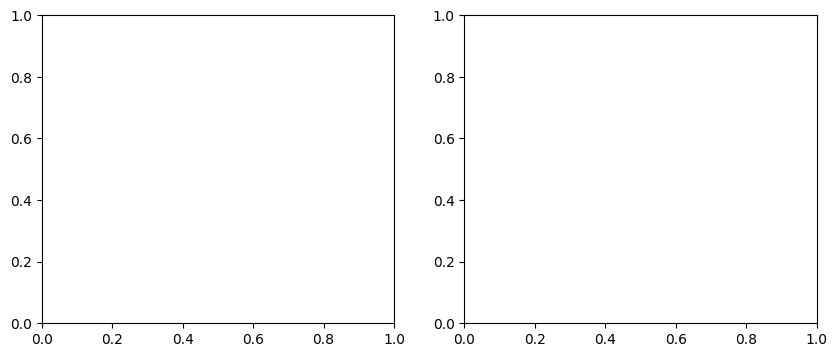

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [19]:
y_predict=model.predict(test_generator)

699/699 [==============================] - 7s 10ms/step


In [20]:
import numpy as np
predictions=[]
for y_pred in y_predict:
    predictions.append(np.argmax(y_pred))

predictions = np.array(predictions)
predictions.shape

(699,)

In [21]:
labels = test_generator.labels

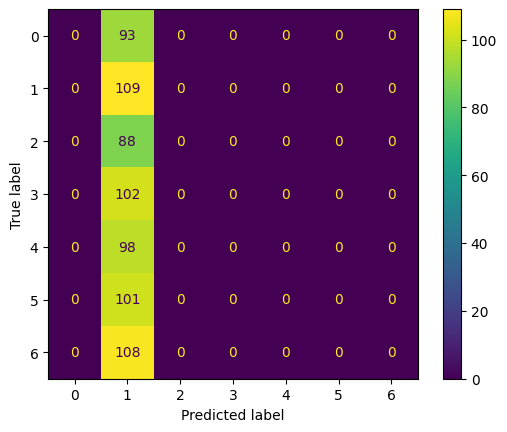

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
target_names = list(test_generator.class_indices.keys())

In [ ]:
target_names

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.79      0.84      0.81        93
     compost       0.87      0.89      0.88       109
       glass       0.76      0.67      0.71        88
       metal       0.80      0.75      0.77       102
       paper       0.72      0.74      0.73        98
     plastic       0.69      0.71      0.70       101
       trash       0.65      0.65      0.65       108

    accuracy                           0.75       699
   macro avg       0.75      0.75      0.75       699
weighted avg       0.75      0.75      0.75       699



## Save model

Sau khi save xong hãy tải xuống và up lên drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!mkdir pretrained_models

In [ ]:
%cd pretrained_models

/content/drive/MyDrive/pretrained_models


In [ ]:
model.save('VGG16_transfer')

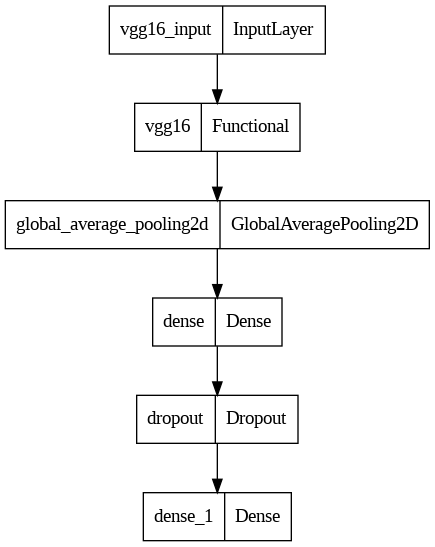

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

## Load model

https://drive.google.com/file/d/1MbuKbhbSww57MAR9tZcFCSkOBFcBdQ7h/view?usp=drive_link

In [ ]:
!gdown 1MbuKbhbSww57MAR9tZcFCSkOBFcBdQ7h

Downloading...
From: https://drive.google.com/uc?id=1MbuKbhbSww57MAR9tZcFCSkOBFcBdQ7h
To: /content/VGG16_transfer.zip
100% 57.2M/57.2M [00:02<00:00, 24.4MB/s]


In [ ]:
!unzip VGG16_transfer.zip

Archive:  VGG16_transfer.zip
   creating: VGG16_transfer/assets/
  inflating: VGG16_transfer/keras_metadata.pb  
  inflating: VGG16_transfer/variables/variables.index  
  inflating: VGG16_transfer/saved_model.pb  
  inflating: VGG16_transfer/fingerprint.pb  
  inflating: VGG16_transfer/variables/variables.data-00000-of-00001  


In [ ]:
import tensorflow as tf

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('VGG16_transfer')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,980,935
Trainable params: 266,247
Non-trainable params: 14,714,688
______________________________________

## Error Analysis

In [ ]:
y_predict=new_model.predict(test_generator)

699/699 [==============================] - 15s 10ms/step


In [ ]:
import numpy as np
predictions=[]
for y_pred in y_predict:
    predictions.append(np.argmax(y_pred))

predictions = np.array(predictions)
predictions.shape

(699,)

In [ ]:
labels = test_generator.labels

In [ ]:
from
for img in test_generator.image_data_generator:


In [ ]:
import matplotlib.pyplot as plt


for i in range(0,699):
    image = x[0]
x = test_generator.next()
    plt.imshow(image)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

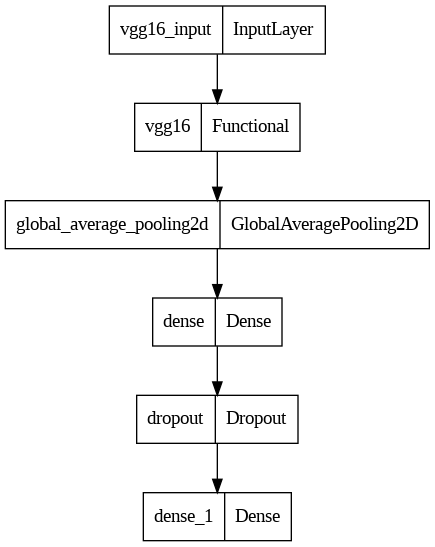

In [ ]:
tf.keras.utils.plot_model(
    new_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

Output hidden; open in https://colab.research.google.com to view.